In [1]:
from scipy.io import loadmat
import mat73
import matplotlib.pyplot as plt
from hmmlearn import hmm
import numpy as np
from tqdm import notebook
from scipy import stats
from scipy.signal import hilbert
from scipy.signal import butter, sosfiltfilt
from scipy import signal
from scipy.fft import fftshift
from kneed import KneeLocator
import pickle
import joblib
import os
import sys
sys.path.append('../libraries/') # Append the path within which the user-defined class is in
from data_loader import data_loader
from behavior_loader import bsoid_loader
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.decomposition import PCA
import umap
import hdbscan

In [2]:
data_dir = r'../processed_data'

### Load 4-hour z-scored non-overlapping bandpower features of lpf using Welch method

In [4]:
zscore_feats = pickle.load(open(os.path.join(data_dir, 'welch_bp/welch_nonoverlap_zscore_bp_0.0_s_offset.np'), 'rb'))
print(f'Z-scored bandpower features are binned into shape: {zscore_feats.shape}')

Z-scored bandpower features are binned into shape: (48, 14400)


In [5]:
def rf_f1_score(X, y, test_size=0.2, average='macro'):
    sample_size = np.ceil(1 / test_size) * 4
    targets, target_cnts = np.unique(y, return_counts=True)
    X_train_arr = [] 
    X_test_arr = [] 
    y_train_arr = [] 
    y_test_arr = []
    for i, target_cnt in enumerate(target_cnts):
        if target_cnt >= sample_size:
            target_idcs = np.where(y == targets[i])[0]
            X_train_target, X_test_target, y_train_target, y_test_target = train_test_split(X[target_idcs, :], y[target_idcs], test_size=test_size, random_state=42)
            X_train_arr.append(X_train_target)
            X_test_arr.append(X_test_target)
            y_train_arr.append(y_train_target)
            y_test_arr.append(y_test_target)
    X_train = np.vstack(X_train_arr)
    X_test = np.vstack(X_test_arr)
    y_train = np.hstack(y_train_arr)
    y_test = np.hstack(y_test_arr)
    clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced_subsample', n_jobs=-1)
    clf.fit(X_train, y_train)
    predict = clf.predict(X_test)

    return f1_score(y_test, predict, average=average)

In [13]:
reducer = umap.UMAP(n_components=5, n_neighbors=60, min_dist=0, random_state=29)
embedding = reducer.fit_transform(zscore_feats.T)
min_cluster_size = 150
min_samples = 20
clusterer_umap = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, prediction_data=True).fit(embedding)
X = zscore_feats[:, clusterer_umap.labels_ >= 0]
y = clusterer_umap.labels_[clusterer_umap.labels_ >= 0]
clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced_subsample', n_jobs=-1)
clf.fit(X.T, y)
y_all = clf.predict(zscore_feats.T)
print(rf_f1_score(zscore_feats.T, y_all, test_size=0.2, average='macro') - (1 / len(np.unique(y_all))))

0.7764416924603188


In [6]:
config = []
rf_score_offset_arr = []
for state in notebook.tqdm(range(100)):
  reducer = umap.UMAP(n_components=5, n_neighbors=60, min_dist=0, random_state=state)
  embedding = reducer.fit_transform(zscore_feats.T)
  for min_cluster_size in range(150, 301, 50):
    for min_samples in range(15, 21, 5):
      # min_cluster_size = 300
      # min_samples = 15
      clusterer_umap = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, prediction_data=True).fit(embedding)
      X = zscore_feats[:, clusterer_umap.labels_ >= 0]
      y = clusterer_umap.labels_[clusterer_umap.labels_ >= 0]
      clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced_subsample', n_jobs=-1)
      clf.fit(X.T, y)
      y_all = clf.predict(zscore_feats.T)
      rf_f1_score_offset = rf_f1_score(zscore_feats.T, y_all, test_size=0.2, average='macro') - (1 / len(np.unique(y_all)))
      rf_score_offset_arr.append(rf_f1_score_offset)
      config.append({'umap_state': state,
                      'min_cluster_size': min_cluster_size,
                      'min_samples': min_samples,
                      'cluster number': len(np.unique(y_all)),
                      'rf_f1_score_offset': rf_f1_score_offset})

  0%|          | 0/100 [00:00<?, ?it/s]

In [7]:
print(f'The config that yields most distinctive umap embedding is f{config[np.argmax(np.array(rf_score_offset_arr))]}')

The config that yields most distinctive umap embedding is f{'umap_state': 29, 'min_cluster_size': 150, 'min_samples': 20, 'cluster number': 10, 'rf_f1_score_offset': 0.7764416924603188}


In [12]:
a = pickle.load(open(os.path.join(data_dir, 'umap_rf_score_100_seed.np'), 'rb'))
b = pickle.load(open(os.path.join(data_dir, 'umap_rf_score_100_seed_config.np'), 'rb'))
np.argmax(a)
b[29]

{'umap_state': 29,
 'min_cluster_size': 300,
 'min_samples': 15,
 'cluster number': 6,
 'rf_f1_score_offset': 0.725896041123705}

In [8]:
pickle.dump(np.array(rf_score_offset_arr), open(os.path.join(data_dir, 'umap_rf_score_100_seed_minsize_150_301_50_minsample_15_21_5.np'), 'wb'))
pickle.dump(config, open(os.path.join(data_dir, 'umap_rf_score_100_seed_minsize_150_301_50_minsample_15_21_5_config.np'), 'wb'))

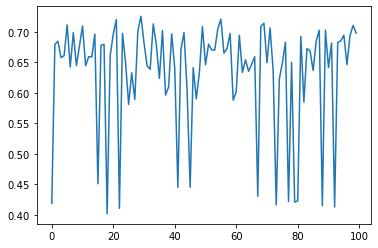

In [11]:
plt.plot(np.arange(100), rf_score_offset_arr)

In [144]:
reducer = umap.UMAP(n_components=5, n_neighbors=60, min_dist=0, random_state=70)
embedding = reducer.fit_transform(zscore_feats.T)

In [145]:
embedding.T[:10]

array([[ 6.860213  ,  7.7749257 ,  8.623017  , ...,  7.0557995 ,
         9.100187  , 10.215359  ],
       [-0.9884043 , -0.04163307,  1.1386051 , ..., -0.77418715,
        -0.4034599 , -0.34385875],
       [ 2.9300632 ,  2.980276  ,  3.254479  , ...,  2.36194   ,
         3.0201035 ,  3.4892979 ],
       [ 5.4002924 ,  4.4998846 ,  3.9443657 , ...,  3.4485781 ,
         2.5773687 ,  2.8750126 ],
       [ 5.0943356 ,  4.37371   ,  3.1922631 , ...,  5.0303974 ,
         4.518363  ,  4.8273373 ]], dtype=float32)

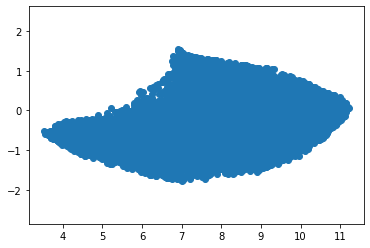

In [146]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1])
plt.gca().set_aspect('equal', 'datalim')

## Least number of low dimension that retains beyond 75% variance using PCA is good

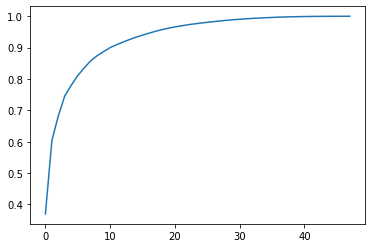

In [100]:
pca = PCA().fit(zscore_feats.T)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [101]:
np.cumsum(pca.explained_variance_ratio_)[4]

0.7803081361637102

In [147]:
clusterer_umap = hdbscan.HDBSCAN(min_cluster_size=300, min_samples=15, prediction_data=True).fit(embedding)

In [148]:
np.unique(clusterer_umap.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3]), array([7678,  333, 2176,  354, 3859]))

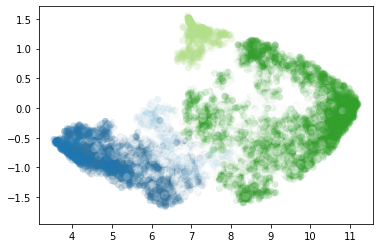

In [149]:
color_palette = sns.color_palette('Paired', 12)
cluster_colors = [color_palette[x] if x >= 0
                  else (1, 1, 1)
                  for x in clusterer_umap.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer_umap.probabilities_)]
plt.scatter(embedding.T[0, :], embedding.T[1, :], s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

## Use non-noise data to build a classifier

In [150]:
X = zscore_feats[:, clusterer_umap.labels_ >= 0]
y = clusterer_umap.labels_[clusterer_umap.labels_ >= 0]

In [151]:
np.unique(y, return_counts=True)

(array([0, 1, 2, 3]), array([ 333, 2176,  354, 3859]))

In [152]:
clf_all = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced_subsample', n_jobs=-1)
clf_all.fit(X.T, y)

RandomForestClassifier(class_weight='balanced_subsample', n_estimators=200,
                       n_jobs=-1, random_state=42)

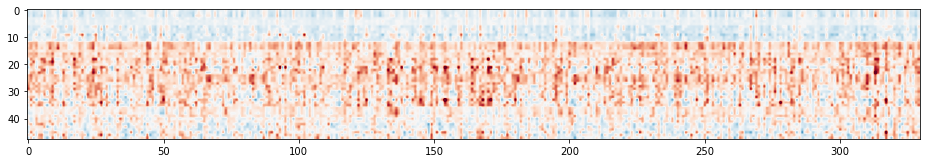

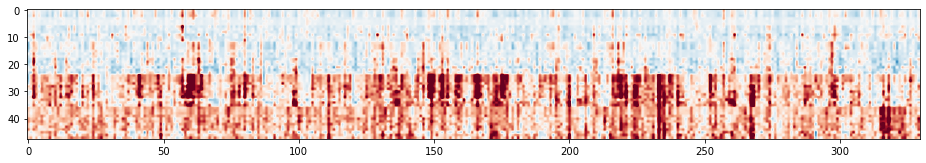

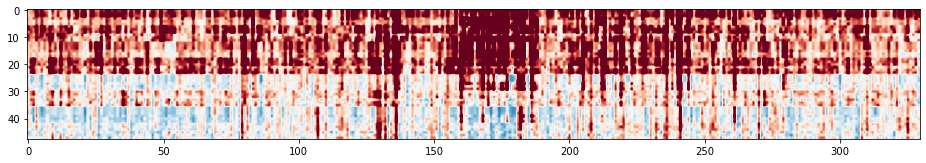

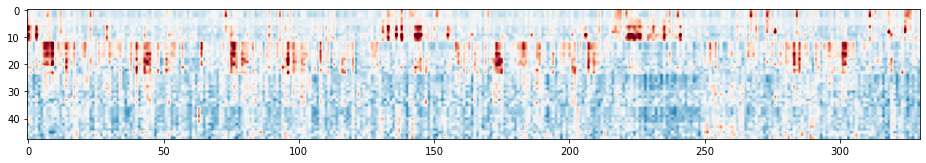

In [192]:
Z2 = y
rows = len(np.unique(Z2))
cols = 1
for lfp_state in np.unique(Z2):
    fig, ax = plt.subplots(1, 1, figsize=(16, 11), sharex=True, sharey=True)
    idx_ = np.where(Z2==lfp_state)[0]
    ax.imshow(X[:, idx_[:330]], vmin=-3, vmax=3, cmap='RdBu_r')

## Classify the noise data as well

In [154]:
lfp_states_predict = clf_all.predict(zscore_feats.T)

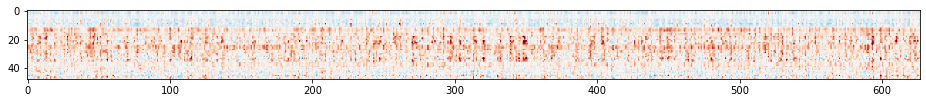

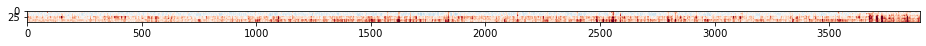

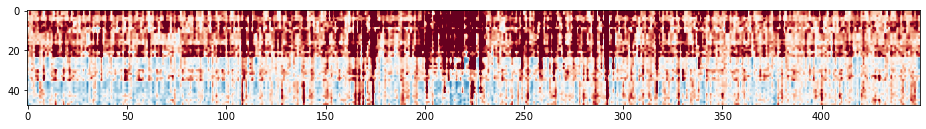

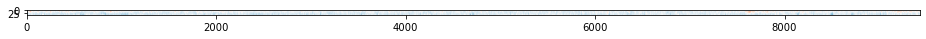

In [155]:
Z2 = lfp_states_predict
rows = len(np.unique(Z2))
cols = 1
for lfp_state in np.unique(Z2):
    fig, ax = plt.subplots(1, 1, figsize=(16, 11), sharex=True, sharey=True)
    idx_ = np.where(Z2==lfp_state)[0]
    ax.imshow(zscore_feats[:, idx_], vmin=-3, vmax=3, cmap='RdBu_r')

## Demonstrate the clustering method works well

In [165]:
X_train_target, X_test_target, y_train_target, y_test_target = train_test_split(X.T, y, test_size=0.2, random_state=42)

In [166]:
clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced_subsample', n_jobs=-1)
clf.fit(X_train_target, y_train_target)

RandomForestClassifier(class_weight='balanced_subsample', n_estimators=200,
                       n_jobs=-1, random_state=42)

In [167]:
predict = clf.predict(X_test_target)

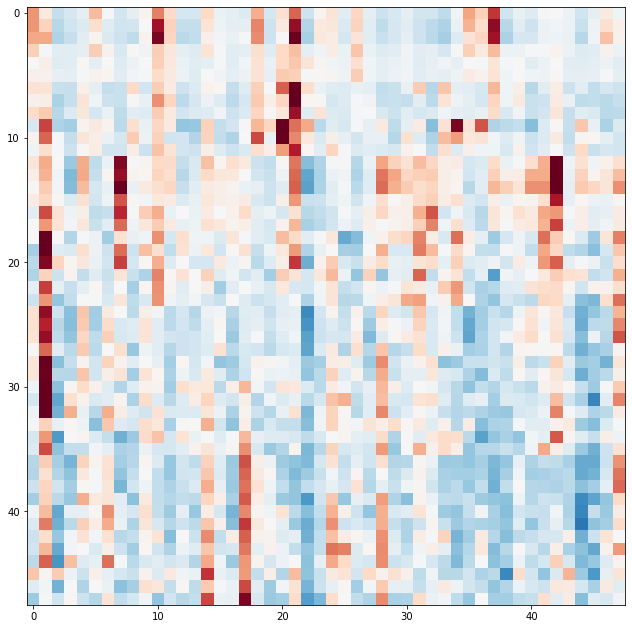

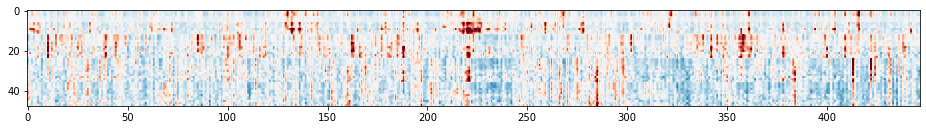

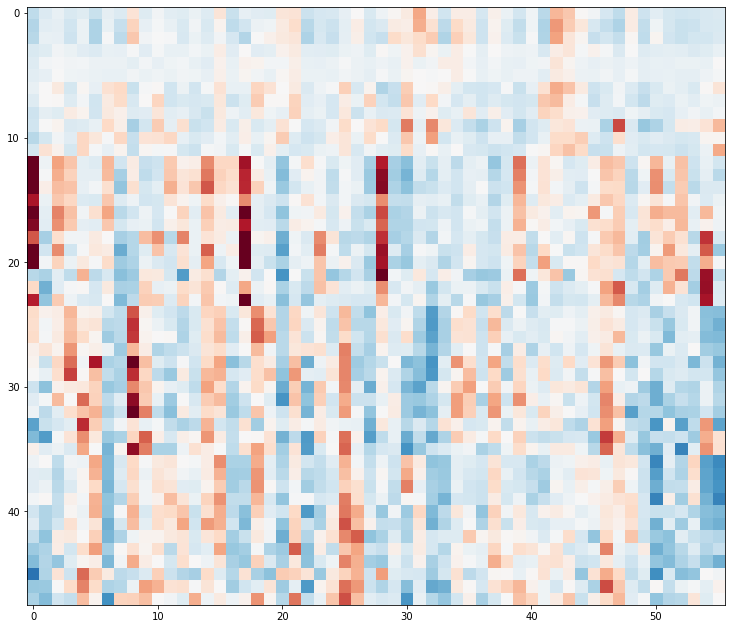

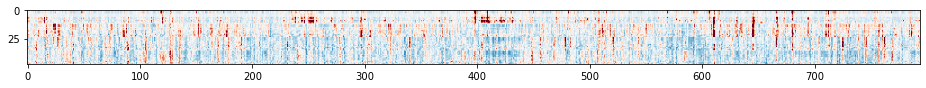

In [159]:
Z2 = predict
rows = len(np.unique(Z2))
cols = 1
for lfp_state in np.unique(Z2):
    fig, ax = plt.subplots(1, 1, figsize=(16, 11), sharex=True, sharey=True)
    idx_ = np.where(Z2==lfp_state)[0]
    ax.imshow(zscore_feats[:, idx_], vmin=-3, vmax=3, cmap='RdBu_r')

In [168]:
f1_score(y_test_target, predict, average='macro')

0.9469178352995712

## Calculate Transition Matrix

In [169]:
lfp_states_predict.shape

(14400,)

In [171]:
K = len(np.unique(lfp_states_predict))

In [172]:
trans_mtx = np.zeros((K, K))

In [178]:
for lfp_state in np.unique(lfp_states_predict):
    lfp_state_idx = np.where(lfp_states_predict == lfp_state)[0]
    try:
        lfp_states_entailed = lfp_states_predict[lfp_state_idx + 1]
    except:
        lfp_states_entailed = lfp_states_predict[lfp_state_idx[:-1] + 1]
    _, uniq_lfp_states_entailed_cnts = np.unique(lfp_states_entailed, return_counts=True)
    trans_mtx[lfp_state, :] = uniq_lfp_states_entailed_cnts / np.sum(uniq_lfp_states_entailed_cnts)

plot states transition using networkX

A>B>C if B is nessce yt ogo from aa-c, COMPARE a-bC WIT a C

In [ ]:
for lfp_state in np.unique(lfp_states_predict):
    lfp_state_idx = np.where(lfp_states_predict == lfp_state)[0]
    try:
        lfp_states_entailed = lfp_states_predict[lfp_state_idx + 1]
    except:
        lfp_states_entailed = lfp_states_predict[lfp_state_idx[:-1] + 1]
    _, uniq_lfp_states_entailed_cnts = np.unique(lfp_states_entailed, return_counts=True)
    trans_mtx_cnts[lfp_state, :] = uniq_lfp_states_entailed_cnts

In [209]:
trans_mtx

array([[0.08452951, 0.27272727, 0.01754386, 0.62519936],
       [0.04569961, 0.46444159, 0.03286264, 0.45699615],
       [0.01777778, 0.23777778, 0.26444444, 0.48      ],
       [0.04115837, 0.19168346, 0.02036703, 0.74679113]])

<AxesSubplot:>

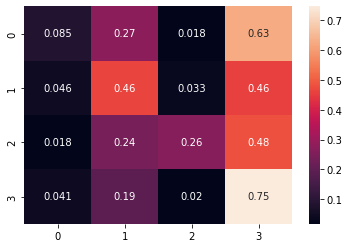

In [181]:
sns.heatmap(trans_mtx, annot=True)

## Baseline spike counts for each state

### Load 4-hour l5 spikes

In [206]:
type(os.path.join(data_dir, 'm1_fr0.1hz_30hz_0s_7200s_0.1s_bins_nooverlap.sav'))

str

In [208]:
with open(os.path.join(data_dir, 'm1_fr0.1hz_30hz_0s_14400s_0.1s_bins_nooverlap.sav'), 'rb') as file:
    spike_times_all_neurons = joblib.load(file)

# Convert to numpy array
spike_times_all_neurons = np.array(spike_times_all_neurons)

# Transpose into (71999, 90)
spike_times_all_neurons = spike_times_all_neurons.T

# Truncate two hour m1 recording to one hour l5 recording into (36000, 46), 
# 0th to 45th L5/6, 46th to 89th L2/3, 89th being the most shallow
spike_times_l5_neurons_4h = spike_times_all_neurons[:, :46]

# # (Number of 100-ms bins, Number of l2 neurons)
# T_1h, D_m1 = spike_times_all_neurons_1h.shape

# Z-score each neuron, i.e. firing rates of each neuron across time sum to 0
spike_times_l5_neurons_4h_zscored = stats.zscore(spike_times_l5_neurons_4h) # Default axis is 0

spikes = spike_times_l5_neurons_4h_zscored
print(f'Spike times are binned into shape: {spikes.shape}')

KeyError: 0

In [200]:
import joblib

## Load 4-hour behaviour

In [184]:
# Load behaviors
behavior_loader = bsoid_loader(data_dir, 'ag25290_day2_iter13')
f_index, filtered_data, smoothed_predictions = behavior_loader.main()

# Correct prediction start
framerate = 60
delay = 6.8503
behavior_start = int(delay * framerate)  # start of behavior
smoothed_predictions_4h = smoothed_predictions[behavior_start:(behavior_start+14400*60):int(60/10)]

Mouse stayed in nest for 0.28108749470484795% of time
Smooth window: 6
File #0 (a 6 body parts by 984391 frames) has 30 classes


In [186]:
behav_names_mod = ['insignificant', 'insignificant', 'insignificant', 'insignificant', 'rear',
         'insignificant', 'insignificant', 'investigate type 1', 'investigate type 2', 'contra-itch',
         'investigate type 3', 'insignificant', 'insignificant', 'insignificant', 'contra-body groom',
         'face groom type 1', 'dive/scrunch', 'head groom', 'ipsi-orient', 'insignificant',
         'face groom type 2', 'ipsi-body groom', 'ipsi-itch type 1', 'insignificant', 'insignificant', 
         'paw groom', 'locomotion', 'insignificant', 'contra-orient']

### Classify behaviors within lfp states

In [187]:
def data_seg_prepare(data, targets, spikes, smoothed_predictions, random_state=10, limit_count=100, verbose=False):
    X = data.copy()
    y = targets.copy()
    X_subsampled = []
    y_subsampled = []
    spikes_subsampled = []
    smoothed_predictions_subsampled = []

    rng = np.random.default_rng(random_state)
    sig_behavs = [i for i, s in enumerate(behav_names_mod) if s != 'insignificant']
    for sig_behav in sig_behavs:
        idcs_s = np.where(y == sig_behav)[0]
        idcs_s_all = np.where(smoothed_predictions_4h == sig_behav)[0]
        try:
            sampled_idcs_s = rng.choice(len(idcs_s), limit_count, replace=False)
            sampled_idcs_s_all = rng.choice(len(idcs_s_all), limit_count, replace=False)
        except:
            sampled_idcs_s = rng.choice(len(idcs_s), len(idcs_s), replace=False)
            sampled_idcs_s_all = rng.choice(len(idcs_s_all), len(idcs_s), replace=False)
        y_subsampled.append(y[idcs_s[sampled_idcs_s]])
        X_subsampled.append(X[idcs_s[sampled_idcs_s], :])          
        smoothed_predictions_subsampled.append(smoothed_predictions[idcs_s_all[sampled_idcs_s_all]])
        spikes_subsampled.append(spikes[idcs_s_all[sampled_idcs_s_all], :])
            
    if verbose:
        print(np.hstack(y_subsampled).shape, np.vstack(X_subsampled).shape)

    return np.hstack(y_subsampled), np.vstack(X_subsampled), np.hstack(smoothed_predictions_subsampled), np.vstack(spikes_subsampled)

In [199]:
def rf_f1_score(X, y, test_size=0.2):
    sample_size = np.ceil(1 / test_size) * 4
    targets, target_cnts = np.unique(y, return_counts=True)
    X_train_arr = [] 
    X_test_arr = [] 
    y_train_arr = [] 
    y_test_arr = []
    for i, target_cnt in enumerate(target_cnts):
        if target_cnt >= sample_size:
            target_idcs = np.where(y == targets[i])[0]
            X_train_target, X_test_target, y_train_target, y_test_target = train_test_split(X[target_idcs, :], y[target_idcs], test_size=test_size, random_state=42)
            X_train_arr.append(X_train_target)
            X_test_arr.append(X_test_target)
            y_train_arr.append(y_train_target)
            y_test_arr.append(y_test_target)
    X_train = np.vstack(X_train_arr)
    X_test = np.vstack(X_test_arr)
    y_train = np.hstack(y_train_arr)
    y_test = np.hstack(y_test_arr)
    clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced_subsample', n_jobs=-1)
    clf.fit(X_train, y_train)
    print(np.unique(y_train, return_counts=True))
    predict = clf.predict(X_test)

    return np.unique(y_test), f1_score(y_test, predict, average=None)

In [ ]:
f1_score_diffs = []
f1_score_smooth_behav_arrs = []
for seed in notebook.tqdm(range(100, 201)):
    uiq_y_arr = []
    f1_score_diff = []
    f1_score_smooth_behav_arr = []
    for lfp_state in np.unique(lfp_states_predict):
        seg_idcs = np.where(lfp_states_predict == lfp_state)[0]
        state_spikes = spikes[seg_idcs, :]
        state_smoothed_predictions_1h = smoothed_predictions_4h[seg_idcs]
        
        state_smoothed_predictions_subsampled, state_spikes_subsampled, smoothed_predictions_subsampled, spikes_subsampled = \
            data_seg_prepare(state_spikes, state_smoothed_predictions_1h, spikes, smoothed_predictions_4h, random_state=seed)
        
        uiq_y, f1_score_sep_behav = rf_f1_score(state_spikes_subsampled, state_smoothed_predictions_subsampled)
        uiq_y_arr.append(uiq_y)
        
        _, f1_score_smooth_behav = rf_f1_score(spikes_subsampled, smoothed_predictions_subsampled)

        f1_score_diff.append(f1_score_sep_behav - f1_score_smooth_behav)
        f1_score_smooth_behav_arr.append(f1_score_smooth_behav)
    f1_score_smooth_behav_arrs.append(f1_score_smooth_behav_arr)
    f1_score_diffs.append(f1_score_diff)

In [ ]:
for i in range(len(np.unique(lfp_states_predict))):
    state_f1_score_arr = []
    for f1_score_diff in f1_score_diffs:
        state_f1_score_arr.append(f1_score_diff[i])
    state_f1_score = np.vstack(state_f1_score_arr)
    state_f1_score_mean = np.mean(state_f1_score, axis=0)
    state_f1_score_std = np.std(state_f1_score, axis=0)

    plt.figure(i)
    plt.bar(np.arange(len(uiq_y_arr[i])), state_f1_score_mean)
    plt.errorbar(np.arange(len(uiq_y_arr[i])), state_f1_score_mean, yerr=state_f1_score_std, ecolor='black', capsize=4, fmt = ' ')
    plt.xticks(np.arange(len(uiq_y_arr[i])), uiq_y_arr[i])